# Capstone Project - Flight Delays
# Does weather events have impact the delay of flights (Brazil)?

### It is important to see this notebook with the step-by-step of the dataset cleaning process:
[https://github.com/davicsilva/dsintensive/blob/master/notebooks/flightDelayPrepData_v2.ipynb](https://github.com/davicsilva/dsintensive/blob/master/notebooks/flightDelayPrepData_v2.ipynb)

In [1]:
from datetime import datetime

# Pandas and NumPy
import pandas as pd
import numpy as np

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns

In [2]:
# 1. Flight delay: any flight with (real_departure - planned_departure >= 15 minutes)
# 2. The Brazilian Federal Agency for Civil Aviation (ANAC) does not define exactly what is a "flight delay" (in minutes)
# 3. Anyway, the ANAC has a resolution for this subject: https://goo.gl/YBwbMy (last access: nov, 15th, 2017)
# ---
# DELAY, for this analysis, is defined as greater than 15 minutes (local flights only)
DELAY = 15

### 1 - Dataset: sample of local flights dataset (700 records)

In [3]:
# Dataset: a sample with 700 records with flights that occurred in the beginning of 2017 (January to June)
flights = pd.read_csv('data/arf2017ISO-sample.csv', sep = ';', dtype = str)

In [4]:
# Using "lambda" to format "date" columns to ISO format: YYYY-MM-DD hh:mm:ss
flights['departure-est'] = flights[['departure-est']].apply(lambda row: row.str.replace("(?P<day>\d{2})/(?P<month>\d{2})/(?P<year>\d{4}) (?P<HOUR>\d{2}):(?P<MIN>\d{2})", "\g<year>/\g<month>/\g<day> \g<HOUR>:\g<MIN>:00"), axis=1)
flights['departure-real'] = flights[['departure-real']].apply(lambda row: row.str.replace("(?P<day>\d{2})/(?P<month>\d{2})/(?P<year>\d{4}) (?P<HOUR>\d{2}):(?P<MIN>\d{2})", "\g<year>/\g<month>/\g<day> \g<HOUR>:\g<MIN>:00"), axis=1)
flights['arrival-est'] = flights[['arrival-est']].apply(lambda row: row.str.replace("(?P<day>\d{2})/(?P<month>\d{2})/(?P<year>\d{4}) (?P<HOUR>\d{2}):(?P<MIN>\d{2})", "\g<year>/\g<month>/\g<day> \g<HOUR>:\g<MIN>:00"), axis=1)
flights['arrival-real'] = flights[['arrival-real']].apply(lambda row: row.str.replace("(?P<day>\d{2})/(?P<month>\d{2})/(?P<year>\d{4}) (?P<HOUR>\d{2}):(?P<MIN>\d{2})", "\g<year>/\g<month>/\g<day> \g<HOUR>:\g<MIN>:00"), axis=1)

In [5]:
# Departure and Arrival columns: from 'object' to 'date' format
flights['departure-est'] = pd.to_datetime(flights['departure-est'],errors='ignore')
flights['departure-real'] = pd.to_datetime(flights['departure-real'],errors='ignore')
flights['arrival-est'] = pd.to_datetime(flights['arrival-est'],errors='ignore')
flights['arrival-real'] = pd.to_datetime(flights['arrival-real'],errors='ignore')

In [6]:
# translate the flight status from portuguese to english
flights['flight-status'] = flights[['flight-status']].apply(lambda row: row.str.replace("REALIZADO", "ACCOMPLISHED"), axis=1)
flights['flight-status'] = flights[['flight-status']].apply(lambda row: row.str.replace("CANCELADO", "CANCELED"), axis=1)

In [7]:
flights[["departure-est", "departure-real", "arrival-est", "arrival-real", "flight-status"]].head(3)

,departure-est,departure-real,arrival-est,arrival-real,flight-status
0,2017-01-02 01:20:00,2017-01-02 01:20:00,2017-01-02 09:00:00,2017-01-02 09:00:00,ACCOMPLISHED
1,2017-01-24 01:20:00,2017-01-24 01:20:00,2017-01-24 09:00:00,2017-01-24 09:00:00,ACCOMPLISHED
2,2017-01-29 01:20:00,2017-01-29 01:20:00,2017-01-29 09:00:00,2017-01-29 09:00:00,ACCOMPLISHED


## Some EDA's tasks

### Flights/airports

In [8]:
# See: https://stackoverflow.com/questions/37287938/sort-pandas-dataframe-by-value 
# or   https://stackoverflow.com/questions/17618981/how-to-sort-pandas-data-frame-using-values-from-several-columns
df_departures = flights.groupby(['airport-A']).size().reset_index(name='number_departures')

In [9]:
df_departures.sort_values(by=['number_departures'], ascending=False, inplace=True)

In [10]:
df_departures.head()

,airport-A,number_departures
38,SBGR,104
13,KMIA,42
25,SAEZ,41
54,SBVT,41
42,SBKP,36


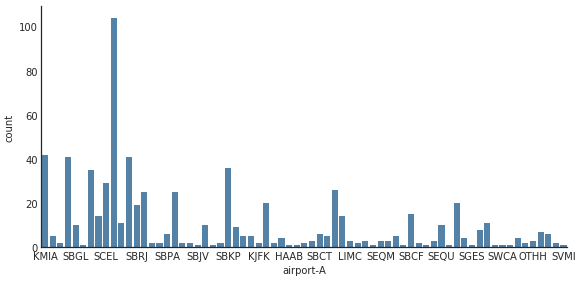

In [36]:
with sns.axes_style('white'):
    g = sns.factorplot("airport-A", data=flights, aspect=2,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=4)

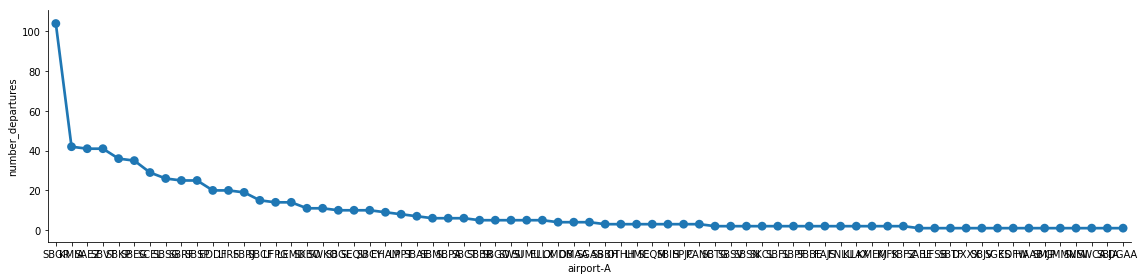

In [51]:
g = sns.factorplot(x="airport-A", y="number_departures", data=df_departures, size=4, aspect=4)

In [52]:
# Get the hour of 'real depature' datetime
# See .dt acessor (http://pandas.pydata.org/pandas-docs/stable/basics.html#basics-dt-accessors)
flights['hour-departure-est'] = flights['departure-est'].dt.hour
flights['hour-departure-real'] = flights['departure-real'].dt.hour
flights['hour-arrival-est'] = flights['arrival-est'].dt.hour
flights['hour-arrival-real'] = flights['arrival-real'].dt.hour

In [53]:
flights.groupby(['airport-A', 'hour-departure-real']).size().groupby(level=1).max()

hour-departure-real
0.0     10
1.0     10
2.0     17
3.0      6
4.0      2
5.0      1
6.0     12
7.0      5
8.0      4
9.0     17
10.0     7
11.0     9
12.0     4
13.0     9
14.0     6
15.0     5
16.0     4
17.0    17
18.0     9
19.0    20
20.0    11
21.0     1
22.0    12
23.0    13
dtype: int64

In [54]:
df_busy_hours = flights.groupby(['hour-departure-real']).size().reset_index(name='flight_by_hour')

In [55]:
df_busy_hours.sort_values(by=['flight_by_hour'], ascending=False, inplace=True)

In [56]:
df_busy_hours.head()

,hour-departure-real,flight_by_hour
19,19.0,76
18,18.0,48
17,17.0,46
2,2.0,34
9,9.0,33


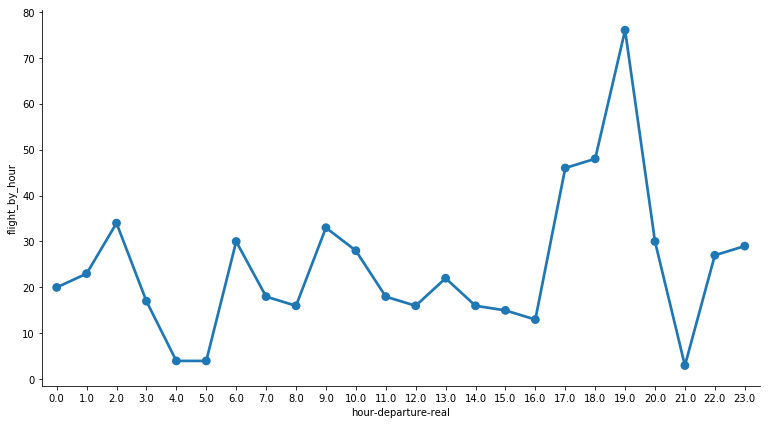

In [57]:
g = sns.factorplot(x="hour-departure-real", y="flight_by_hour", data=df_busy_hours, size=6, aspect=1.8)

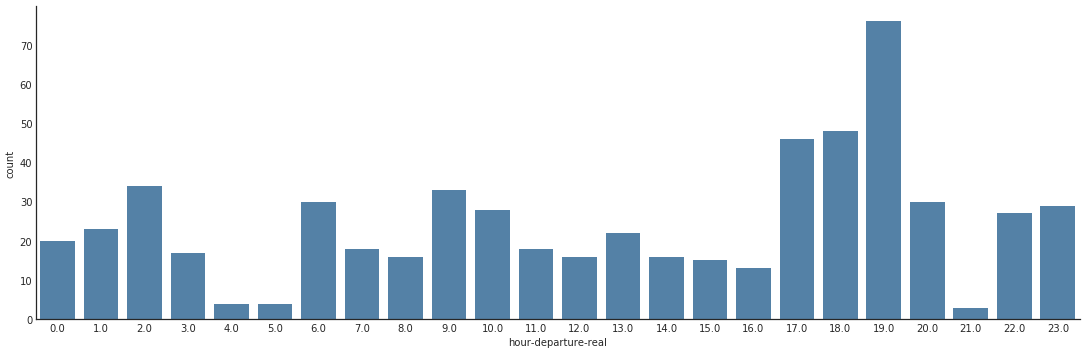

In [58]:
with sns.axes_style('white'):
    g = sns.factorplot("hour-departure-real", data=flights, size=5, aspect=3,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=1)

In [109]:
(flights['departure-real'] - flights['departure-est']).dt.components.head()

,days,hours,minutes,seconds,milliseconds,microseconds,nanoseconds
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
# Get the delta time (real - estimated) for depature and arrival times
# More about 'DateTime' at https://docs.scipy.org/doc/numpy-dev/reference/arrays.datetime.html#datetime-and-timedelta-arithmetic 
flights['delay-departure']=(flights['departure-real'] - flights['departure-est'])
flights['delay-arrival']=(flights['arrival-real'] - flights['arrival-est'])

# Delay (departure and arrival) in minutes (using 'numpy.timedelta64')
# See this link: https://stackoverflow.com/questions/14920903/time-difference-in-seconds-from-numpy-timedelta64
flights['delay-departure']=np.divide(flights[['delay-departure']], np.timedelta64(1, 'm'))
flights['delay-arrival']=np.divide(flights[['delay-arrival']], np.timedelta64(1, 'm'))

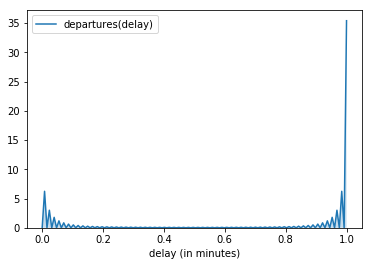

In [114]:
sns.kdeplot(flights['delay-departure'] > 0, label='departures(delay)', shade=True)
plt.xlabel('delay (in minutes)');

### 2 - Local airports (list with all the ~600 brazilian public airports)

Source: https://goo.gl/mNFuPt (a XLS spreadsheet in portuguese; last access on nov, 15th, 2017)

In [ ]:
# Airports dataset: all brazilian public airports (updated until october, 2017)
airports = pd.read_csv('data/brazilianPublicAirports-out2017.csv', sep = ';', dtype= str)

In [ ]:
airports.head()

In [ ]:
# Merge "flights" dataset with "airports" in order to identify 
#   local flights (origin and destination are in Brazil)
flights = pd.merge(flights, airports, left_on="airport-A", right_on="airport", how='left')
flights = pd.merge(flights, airports, left_on="airport-B", right_on="airport", how='left')

In [ ]:
with sns.axes_style('white'):
    g = sns.factorplot("airport-A", data=flights, aspect=2,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=5)

### 3 - List of codes (two letters) used when there was a flight delay (departure)
I have found two lists that define two-letter codes used by the aircraft crew to justify the delay of the flights: a short and a long one.

Source: https://goo.gl/vUC8BX (last access: nov, 15th, 2017)


In [ ]:
# ------------------------------------------------------------------
# List of codes (two letters) used to justify a delay on the flight
# - delayCodesShortlist.csv: list with YYY codes
# - delayCodesLongList.csv: list with XXX codes
# ------------------------------------------------------------------
delaycodes = pd.read_csv('data/delayCodesShortlist.csv', sep = ';', dtype = str)
delaycodesLongList = pd.read_csv('data/delayCodesLonglist.csv', sep = ';', dtype = str)

In [ ]:
delaycodes.head()

### 4 - The Weather data from https://www.wunderground.com/history

From this website I captured a sample data from local airport (Campinas, SP, Brazil): January to September, 2017.

The website presents data like this (see [https://goo.gl/oKwzyH](https://goo.gl/oKwzyH)):

In [ ]:
# Weather sample: load the CSV with weather historical data (from Campinas, SP, Brazil, 2017)
weather = pd.read_csv('data/DataScience-Intensive-weatherAtCampinasAirport-2017-Campinas_Airport_2017Weather.csv', \
                      sep = ',', dtype = str)

In [ ]:
weather["date"] = weather["year"].map(str) + "-" + weather["month"].map(str) + "-" + weather["day"].map(str) 
weather["date"] = pd.to_datetime(weather['date'],errors='ignore')

In [ ]:
weather.head()